In [1]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

In [2]:
# Getting data from google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/temp/

Mounted at /content/drive
/content/drive/My Drive/temp


In [3]:
#Reading file 
df = pd.read_csv("ambient_temperature_system_failure.csv")

To check whether the data is read successfully, we see the header of the file and then visualize the data through plotting. 

In [4]:
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


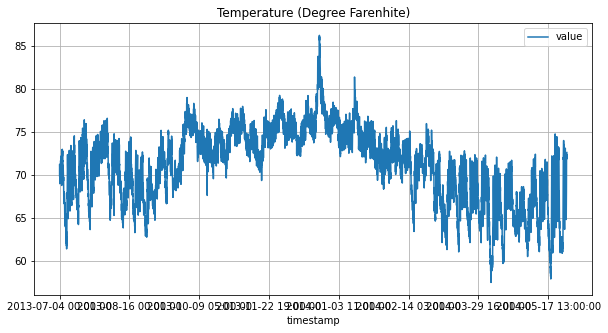

In [5]:
#Visualize the data
figsize=(10,5)
df.plot(x='timestamp', y='value', figsize=figsize, title='Temperature (Degree Farenhite)');
plt.grid();
plt.show();

As we can see that the dates do not appear clearly on the X-axis, we need to change the type of timestamp column. As the temperature in our data set is given in the degree Fahrenheit, we will convert it into degree Celcius. 

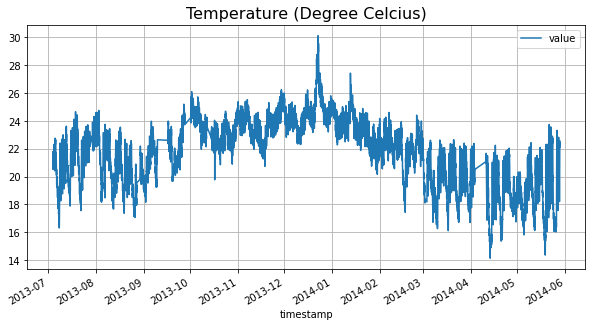

In [6]:
#Changing the type of timestamp column for visualization
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value', figsize=figsize);
plt.title('Temperature (Degree Celcius)', fontsize=16);
plt.grid();
plt.show();

Now we can see the data is visualized perfectly. To check the stability of temperature during days and nights of weekdays and weekends we are going to preprocess our data accordingly. First, we will specify hours, then days, then weekdays and nights. Finally, we will visualize the temperature during these time-periods using a histogram. 

In [7]:
#Formating the data into required format
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

# Anomaly estimated population
outliers_fraction = 0.01

df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

df['categories'] = df['WeekDay']*2 + df['daylight']
a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']


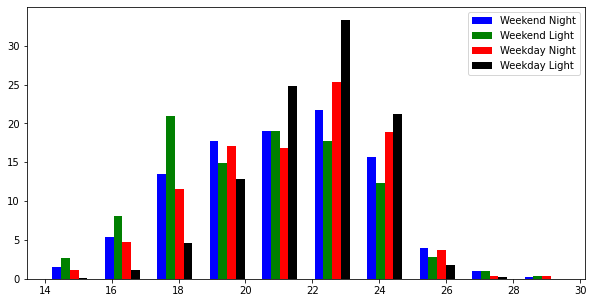

In [8]:
#Visualizing the formatted data
figsize=(10,5)
fig, ax = plt.subplots(figsize=figsize)
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
width = (a_bins[1] - a_bins[0])/6
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Weekend Night')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Weekend Light')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Weekday Night')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='Weekday Light')
plt.legend()
plt.show()

The above histogram shows that the temperature is comparatively more stable during Week Days in the daylights. Now, we will preprocess our dataset for training the LSTM recurrent neural network. For this purpose, first, we will take the required columns from the dataset and scale it using Standard Scaler. 

In [9]:
#Preparing the data for LSTM model
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

In the next step, we will define and initialize the required parameters and define the training and the test data set. We are going to learn from 50 previous values and we predict through the LSTM model just the one next value.

In [10]:
#Important parameters and training/Test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#Training data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values

#Test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

As we know that the architecture of a Recurrent Neural Network has a hidden state. The hidden state at time t is a function of the hidden state at time t−1 and the input at time t. This hidden state at the time 0 is typically initialized to 0. The fundamental reason why RNNs are unrolled is that all previous inputs and hidden states are used in order to compute the gradients with respect to the final output of the RNN. The below unrolling function will create a sequence of 50 previous data points for each of the training and test data point.

In [11]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

Now, we will see the final shape of our training and test data. 

In [12]:
#Shape of the data
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In the next step, we will define and add layers to the LSTM Recurrent Neural Network one-by-one.

In [13]:
#Building the model
model = Sequential()

model.add(LSTM(input_dim=x_train.shape[-1], units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.011561870574951172


Once, the LSTM RNN model is defined and compiled successfully, we will train our model. The below hyperparameters can be tuned to check the better performance.

In [14]:
model.fit(x_train, y_train, batch_size=3028, epochs=50, validation_split=0.1)


Epoch 1/50
2/2 [==============================] - 1s 300ms/step - loss: 0.6084 - val_loss: 0.6729
Epoch 2/50
2/2 [==============================] - 0s 37ms/step - loss: 0.2187 - val_loss: 0.3565
Epoch 3/50
2/2 [==============================] - 0s 38ms/step - loss: 0.1585 - val_loss: 0.3096
Epoch 4/50
2/2 [==============================] - 0s 34ms/step - loss: 0.1223 - val_loss: 0.2437
Epoch 5/50
2/2 [==============================] - 0s 33ms/step - loss: 0.1033 - val_loss: 0.2160
Epoch 6/50
2/2 [==============================] - 0s 35ms/step - loss: 0.0952 - val_loss: 0.1950
Epoch 7/50
2/2 [==============================] - 0s 34ms/step - loss: 0.0977 - val_loss: 0.1978
Epoch 8/50
2/2 [==============================] - 0s 33ms/step - loss: 0.0965 - val_loss: 0.1718
Epoch 9/50
2/2 [==============================] - 0s 35ms/step - loss: 0.0851 - val_loss: 0.1480
Epoch 10/50
2/2 [==============================] - 0s 34ms/step - loss: 0.1109 - val_loss: 0.1467
Epoch 11/50
2/2 [===========

After the successful training of the model, we will visualize the training performance.

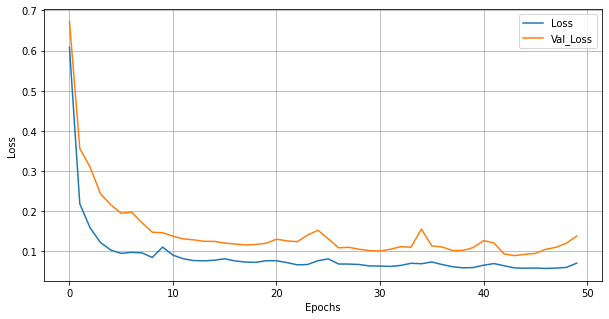

In [15]:
#Visualizing training and validaton loss
plt.figure(figsize = (10, 5))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['val_loss'], Label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

Now, we will execute the below code snippet to better understand the difference between the original data and the predicted data through the visualization.

In [16]:
#creating the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

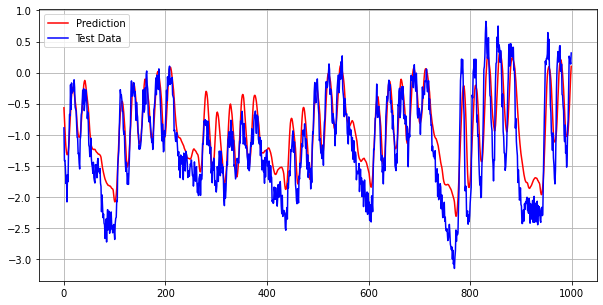

In [17]:
#Plotting the prediction and the reality (for the test data)
plt.figure(figsize = (10, 5))
plt.plot(p,color='red', label='Prediction')
plt.plot(y_test,color='blue', label='Test Data')
plt.legend(loc='upper left')
plt.grid()
plt.legend()

Now, in the next step, we are going to find the anomalies. The most distant predicted values are considered as anomalies. Using the below code snippet, we will find the anomalies in the data.



In [18]:
#Pick the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
#Data with anomaly label
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


Finally, we will visualize the anomalies using the below code for plotting. 

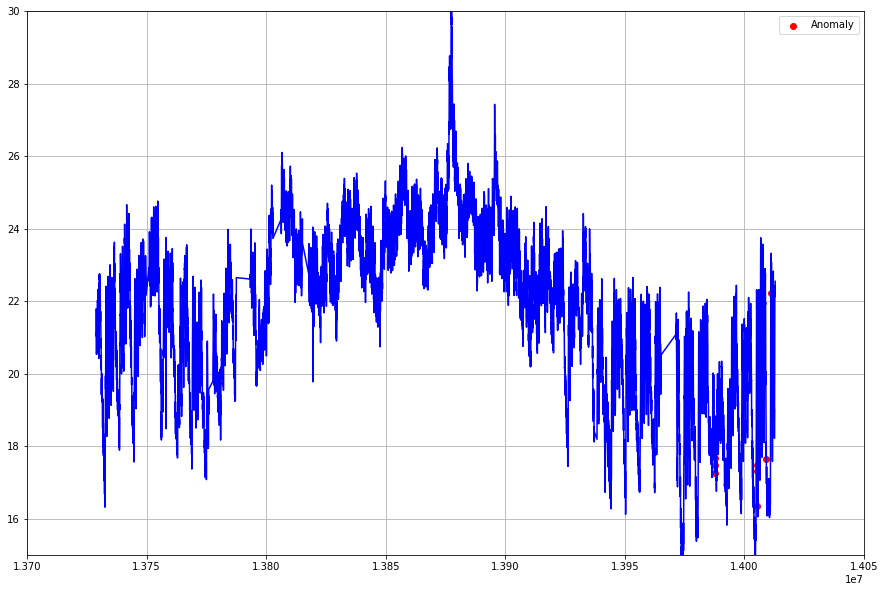

In [19]:
#Visualizing anomalies (Red Dots)
plt.figure(figsize=(15,10))
a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly
plt.plot(df['time_epoch'], df['value'], color='blue')
plt.scatter(a['time_epoch'],a['value'], color='red', label = 'Anomaly')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.grid()
plt.legend()

As we can see in the above picture, the anomalies are visualized as red points. All the above steps can be repeated multiple times to visualize the anomalies by tuning the hyperparameters. If we find the same visualization at the end, then we can end-up with these anomalies. 